In [3]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EL_Cyberbullying/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Exploratory analysis

In [8]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [9]:
#Remove duplicates per row
df.drop_duplicates(inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [10]:
pd.set_option('display.max_colwidth', None)
df_groupby_tweet=df.groupby('tweet_text').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()
df_groupby_tweet[df_groupby_tweet['cyberbullying_type']>1]

,tweet_text,cyberbullying_type
0,What a riveting little lesson in walking the catwalk. Thanks ladies #MKR,2
1,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",2
2,@NedGilmore oh! go get meat from south.,2
3,@kate_1985 - not sure!! But never fear @mykitchenrules still has 751 teams left and another Instant Restaurant round to come. #MKR,2
4,@NetTxt doesn't work that way. Sorry to disappoint you. No one cares what you want.,2
...,...,...
1634,RT @HelpIamaCabbage: @freebsdgirl People are spending money to try to get you temporarily suspended from twitter? That may be the most was…,2
1635,TODO: email tax guy to ask if lavender bath bombs qualify as a business expense.,2
1636,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",2
1637,"RT @DustyPee: If #cuntandandre make it through, I'll... I don't know what I will do. #mkr",2


In [11]:
df[df['tweet_text']=="Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"]

,tweet_text,cyberbullying_type
9109,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",gender
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying


In [12]:
df[df['tweet_text']=="@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself."]

,tweet_text,cyberbullying_type
6686,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",not_cyberbullying
29619,"@KaitlynBurnell to be clear, i'm not bringing this up to defend bri. i'm aware that she's fully capable of defending herself.",other_cyberbullying


In [13]:
#Remove duplicates based on tweet text. Keep only on cyberullying type per tweet
df.drop_duplicates(subset='tweet_text', keep="first", inplace=True)
df.describe()

,tweet_text,cyberbullying_type
count,46017,46017
unique,46017,6
top,"In other words #katandandre, your food was crapilicious! #mkr",religion
freq,1,7995


In [14]:
#Number of tweets per type of cyberbullying (after removing duplicates)
df.groupby('cyberbullying_type').count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


### Preprocess tweets

In [15]:
stemmer = SnowballStemmer("english")
stemmer.stem("studies")

'studi'

In [16]:
lematizer=WordNetLemmatizer()
lematizer.lemmatize("studies")

'study'

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lematizer=WordNetLemmatizer()

def preprocess_tweet(tweet, stem=True):
    #Remove special caracters, links and user tags
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    #Remove stopwords
    tweet=" ".join([word for word in str(tweet).split() if word not in stop_words])
    #Stemming: Removes suffixes and prefixes. Ex. studies->studi.
    if stem==True:
        tweet= " ".join([stemmer.stem(word) for word in tweet.split()])
    #Lemmatizing: Gets the root word (better). studies->study
    tweet=" ".join([lematizer.lemmatize(word) for word in tweet.split()])
    return tweet

In [18]:
#Preprocess tweets
df['tweet_cleaned']=df['tweet_text'].apply(preprocess_tweet)
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie


In [19]:
df.describe()

,tweet_text,cyberbullying_type,tweet_cleaned
count,46017,46017,46017
unique,46017,6,44918
top,"In other words #katandandre, your food was crapilicious! #mkr",religion,
freq,1,7995,271


In [20]:
df.groupby('tweet_cleaned').count().sort_values(by='cyberbullying_type', ascending=False).reset_index()

,tweet_cleaned,tweet_text,cyberbullying_type
0,,271,271
1,fuck dumb nigger,45,45
2,bulli,43,43
3,yes,25,25
4,feminazi,24,24
...,...,...,...
44913,halalflaw biebervalu come moron let go vers quran start 33 33 afraid,1,1
44914,halalflaw biebervalu greenlinerzjm bitch copi hadith go look hadith bitch,1,1
44915,halalflaw biebervalu greenlinerzjm go look word taquiyya,1,1
44916,halalflaw biebervalu greenlinerzjm islam cultur islam religion,1,1


In [21]:
#Remove empty tweets
df.dropna(subset = ["tweet_cleaned"], inplace=True)

In [22]:
df[df['tweet_cleaned']=='feminazi']
#Should be remove duplicates after cleaning tweet?

,tweet_text,cyberbullying_type,tweet_cleaned
8222,@piojaa_ feminazi,gender,feminazi
8503,@Bourgholtzer feminazi,gender,feminazi
9765,FEMINAZI,gender,feminazi
9791,'Feminazi' http://t.co/Y5skW0daNu,gender,feminazi
10138,@Fernandarova feminazi,gender,feminazi
11378,@FunkAd3 feminazi.,gender,feminazi
12134,To feminazi,gender,feminazi
12181,Feminazi (?),gender,feminazi
12385,Feminazi.,gender,feminazi
12817,Feminazi 😳,gender,feminazi


### Word cloud and common words count

Type of cyberbullying: not_cyberbullying


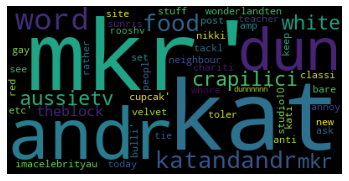


Type of cyberbullying: gender


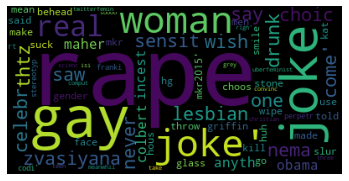


Type of cyberbullying: religion


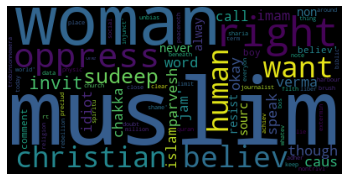


Type of cyberbullying: other_cyberbullying


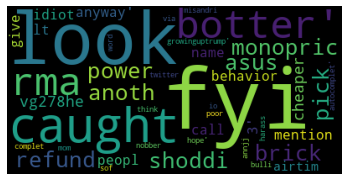


Type of cyberbullying: age


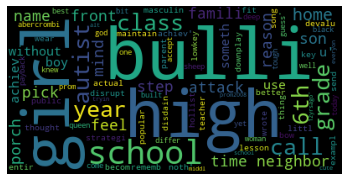


Type of cyberbullying: ethnicity


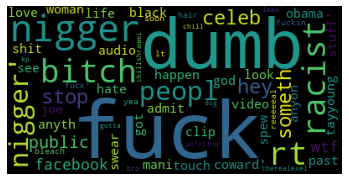

In [23]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  #Generate wordcloud
  wordcloud = WordCloud().generate(str(tweets))
  print("Type of cyberbullying:", i)
  #Display word cloud
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  print("")

Type of cyberbullying: not_cyberbullying
     word  count
0     mkr   1612
1   bulli   1231
2      rt    794
3    like    430
4     get    427
5      go    396
6  school    382
7     kat    300
8     amp    285
9   peopl    274


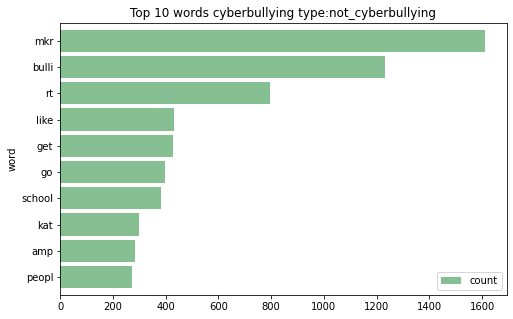


Type of cyberbullying: gender
    word  count
0   joke   5436
1   rape   4423
2    gay   4200
3   call   1411
4   make   1355
5     rt   1241
6  woman   1214
7  bitch   1181
8  femal   1134
9  peopl   1010


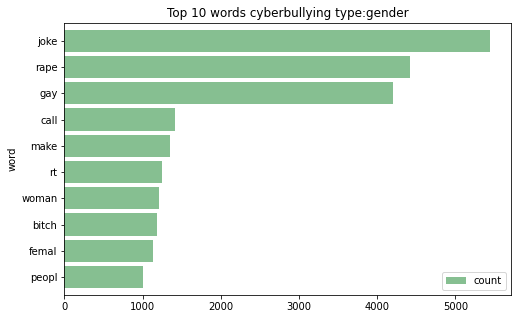


Type of cyberbullying: religion
        word  count
0     muslim   4868
1      idiot   3140
2      islam   2534
3  christian   2222
4          u   2030
5  terrorist   1468
6      right   1349
7       like   1283
8      woman   1279
9    support   1273


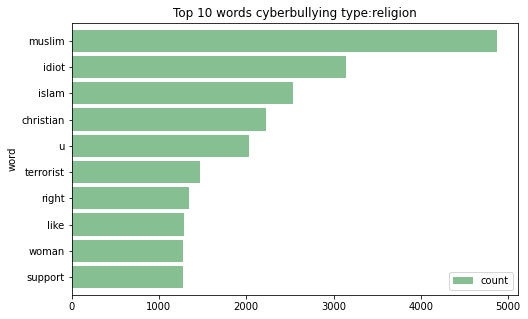


Type of cyberbullying: other_cyberbullying
    word  count
0  bulli    966
1     rt    750
2   fuck    520
3   like    429
4    get    394
5  peopl    354
6     go    279
7  idiot    272
8   know    247
9  think    241


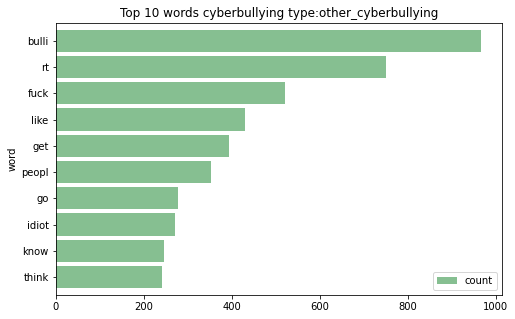


Type of cyberbullying: age
     word  count
0   bulli   9124
1  school   8658
2    high   5095
3    girl   4699
4    like   2094
5     get   1059
6     one   1052
7   peopl    936
8     got    827
9     kid    819


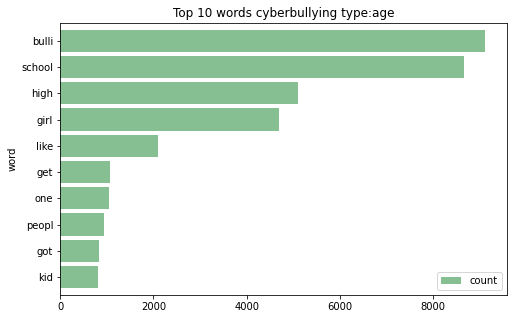


Type of cyberbullying: ethnicity
     word  count
0    fuck   6142
1  nigger   5799
2    dumb   5216
3      as   2303
4   black   2206
5       u   2167
6   white   1608
7    call   1393
8      rt   1221
9   peopl   1193


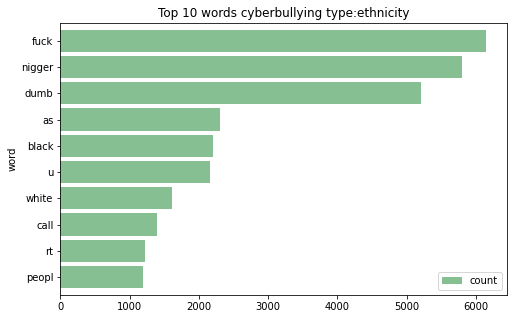

In [24]:
for i in df['cyberbullying_type'].unique():
  #Filter the tweets for each type
  tweets_type=df[df['cyberbullying_type']==i]
  tweets = tweets_type['tweet_cleaned'].values 
  print("Type of cyberbullying:", i)
  #Count frequency for each word and get top 10
  top_words=Counter(" ".join(df["tweet_cleaned"][df['cyberbullying_type']==i]).split()).most_common(10)
  top_words_df=pd.DataFrame(top_words, columns=['word', 'count'])
  print(top_words_df)
  top_words_df=top_words_df.sort_values('count',ascending=True)
  #Make horizontal bar plot to display top 10 words and their frequency
  top_words_df.plot.barh(x='word', y='count', figsize=(8, 5), title="Top 10 words cyberbullying type:"+i, color='#86bf91', zorder=2, width=0.85)
  plt.show()
  print("")

### Feature engineering

In [25]:
#Assign ids to each cyberbullying type
types=df['cyberbullying_type'].unique()
types_ids=[0,1,2,3,4,5]
df_cyber_types=pd.DataFrame(list(zip(types, types_ids)),
               columns =['cyberbullying_type', 'cyberbullying_id'])
df_cyber_types

,cyberbullying_type,cyberbullying_id
0,not_cyberbullying,0
1,gender,1
2,religion,2
3,other_cyberbullying,3
4,age,4
5,ethnicity,5


In [26]:
#Add cyberbullying ids to the full data
df=pd.merge(df, df_cyber_types, how='left', on='cyberbullying_type')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0


In [27]:
#Get the length of the tweet: number of words
df['nwords']=(df['tweet_cleaned'].str.split()).apply(len)
#get number of letters
df['nletters']=(df['tweet_cleaned']).apply(len)
#get number of vowels
df['nvowels']=df['tweet_cleaned'].str.count(r'[aeiou]')
df.head()

,tweet_text,cyberbullying_type,tweet_cleaned,cyberbullying_id,nwords,nletters,nvowels
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,0,5,34,10
1,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,0,11,92,31
2,@XochitlSuckkks a classy whore? Or more red velvet cupcakes?,not_cyberbullying,classi whore red velvet cupcak,0,5,30,9
3,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying,meh p thank head concern anoth angri dude twitter,0,9,49,14
4,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying,isi account pretend kurdish account like islam lie,0,8,50,18


In [28]:
#Describe features for each cyberbullying type
df_features=df[['cyberbullying_type', 'nwords','nletters', 'nvowels']].groupby('cyberbullying_type').median().sort_values(by='nwords')
df_features

,nwords,nletters,nvowels
cyberbullying_type,,,
other_cyberbullying,7.0,42.0,13.0
not_cyberbullying,8.0,44.0,13.0
gender,12.0,72.0,22.0
ethnicity,14.0,77.0,22.0
age,16.0,94.0,29.0
religion,19.0,118.0,38.0


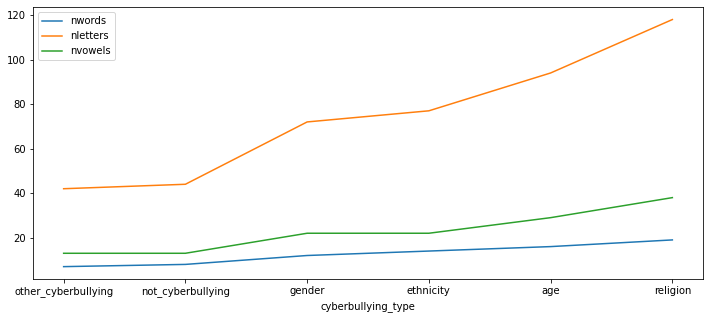

In [29]:
#Plot features
df_features.plot(figsize=(12, 5))

In [41]:
#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_names, y_test_names = train_test_split(np.array(df["tweet_cleaned"]),np.array(df["cyberbullying_id"]), np.array(df['cyberbullying_type']), test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

(34512,)
(11505,)


In [31]:
#TF_IDF Matrix
#initialise the vectorizer and then call fit and transform over it to calculate the TF-IDF score for the text
tf_idf = TfidfVectorizer(use_idf=True, min_df=0.00002, max_df=0.6)
#fit_transform(raw_documents), Parameters: raw_documents : iterable which yields either str, unicode or file objects
tf_idf_train_features = tf_idf.fit_transform(X_train.astype('U'))

tf_idf_test_features = tf_idf.transform(X_test.astype('U'))

print('TFIDF: Train features shape:', tf_idf_train_features.shape, ' Test features shape:', tf_idf_test_features.shape)

TFIDF: Train features shape: (34512, 32868)  Test features shape: (11505, 32868)


In [32]:
#the tuple represents sentence number and feature (word) number. The value in front is the tf-idf weight
#TF-IDF weights words based on relevance, one can use this technique to determine that the words with the highest relevance are the most important
print(tf_idf_train_features)

  (0, 4786)	0.18148708317878656
  (0, 25559)	0.19552250426430687
  (0, 13162)	0.22973943717885265
  (0, 21232)	0.258632132526771
  (0, 19455)	0.68136624772155
  (0, 14818)	0.5872841190264935
  (1, 29203)	0.3037284148782917
  (1, 14034)	0.5310665474779993
  (1, 3894)	0.3289965966953841
  (1, 11657)	0.18524148583663289
  (1, 2802)	0.3007617850512554
  (1, 31401)	0.32453218192542216
  (1, 16892)	0.3025211026414662
  (1, 22148)	0.1749913773233365
  (1, 17686)	0.40650266333664964
  (2, 31626)	0.3302444934413069
  (2, 17198)	0.16855960718373927
  (2, 27836)	0.33264460064404494
  (2, 10246)	0.42177067391322814
  (2, 24943)	0.18730718457967033
  (2, 23799)	0.3789413582625105
  (2, 2921)	0.2559836779095226
  (2, 10798)	0.5742605017880107
  (3, 21875)	0.260542338797588
  (3, 32223)	0.23042545311410112
  :	:
  (34510, 10855)	0.23776514206794963
  (34510, 28402)	0.20832963635406024
  (34510, 22550)	0.2200605911482168
  (34510, 14121)	0.20354802236782316
  (34510, 14657)	0.18040816043346078
  (3451

In [33]:
#Get the list of features names (in our case, features are words) and their index
feature_names={}
for i, feature in enumerate(tf_idf.get_feature_names_out()):
    feature_names[i]= feature
    if i>=23050 and i<=23070:
      print(i, feature_names[i])

23050 primeminist
23051 primer
23052 primero
23053 primila
23054 primit
23055 primordialradio
23056 primp
23057 princ
23058 princearihan
23059 princelaqroix
23060 princeofpersia
23061 princesmunchkin
23062 princess
23063 princessbravato
23064 princesskelsey7
23065 princeton
23066 princip
23067 principl
23068 print
23069 printer
23070 printout


### Modelling and evaluation

In [68]:
#It takes 5-6 min to run
#Define classifiers
clfs = {
    "Decision Tree":DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting":GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss",random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42) #Light Gradient Boosting Machine: usually faster than xgboost   
}

#Fitting function
def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

#Fit models and save accuracies
accuracies = []
for name,clf in clfs.items():
    curr_acc = fit_model(clf,tf_idf_train_features,y_train,tf_idf_test_features,y_test)
    accuracies.append(curr_acc)

In [69]:
#Print and compare performance for all models
models_accuracy_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracies}).sort_values('Accuracy Scores',ascending=False)
models_accuracy_df

,Models,Accuracy Scores
1,Random Forest,0.849544
5,LightGBM,0.846675
2,Gradient Boosting,0.839983
0,Decision Tree,0.827553
3,XGBoost,0.827466
4,AdaBoost,0.796262


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


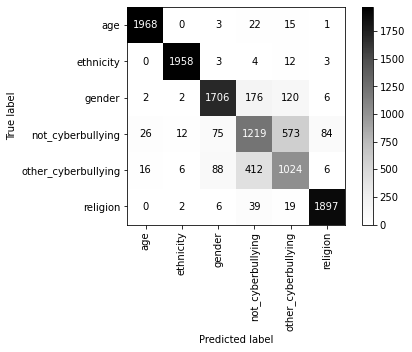

In [43]:
#Train and get predictions from Random Forest (best model)
rf=RandomForestClassifier(random_state=42)
rf=rf.fit(tf_idf_train_features,y_train_names)
rf_predictions = rf.predict(tf_idf_test_features.astype('U'))

#Plot confusion matrix for all cyberbullying types
plot_confusion_matrix(estimator=rf, X=tf_idf_test_features, y_true=y_test_names, 
                      xticks_rotation='vertical', cmap='Greys', ax=None, include_values=True)

In [44]:
print(classification_report(y_test_names, rf_predictions, target_names=list(set(y_test_names))))

                     precision    recall  f1-score   support

          ethnicity       0.98      0.98      0.98      2009
                age       0.99      0.99      0.99      1980
           religion       0.91      0.85      0.88      2012
             gender       0.65      0.61      0.63      1989
  not_cyberbullying       0.58      0.66      0.62      1552
other_cyberbullying       0.95      0.97      0.96      1963

           accuracy                           0.85     11505
          macro avg       0.84      0.84      0.84     11505
       weighted avg       0.85      0.85      0.85     11505

